In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from dask.distributed import Client, LocalCluster

client = Client( # Note that `memory_limit` is the limit **per worker**.
    n_workers=1, 
    threads_per_worker=4,
    memory_limit='16GB')
client # If you click the dashboard link in the output, you can monitor real-time progress and get other cool visualizations.

/Users/abroome/miniconda3/envs/sprinkles/lib/python3.9/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 64933 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:64933/status,
Dashboard: http://127.0.0.1:64933/status,Workers: 1
Total threads: 4,Total memory: 14.90 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:64934,Workers: 1
Dashboard: http://127.0.0.1:64933/status,Total threads: 4
Started: Just now,Total memory: 14.90 GiB
Comm: tcp://127.0.0.1:64939,Total threads: 4
Dashboard: http://127.0.0.1:64940/status,Memory: 14.90 GiB
Nanny: tcp://127.0.0.1:64937,


In [3]:
import os
import copy
import sys
import xarray as xr
import numpy as np
import dask.array as da

import matplotlib.pyplot as plt
import hvplot.xarray
import holoviews as hv
import scipy.constants
import scipy.signal as sp

sys.path.append("..")
import processing_dask as pr
import plot_dask
import processing as old_processing

sys.path.append("../../preprocessing/")
from generate_chirp import generate_chirp

from selenium import webdriver
import chromedriver_binary  # Adds chromedriver binary to path

/Users/abroome/miniconda3/envs/sprinkles/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
# file path to data and configs

#prefix = "/home/radioglaciology/thomas/radar_data/20230721-summit-day1-bench/20230721_104552"
#prefix = "/home/radioglaciology/thomas/radar_data/20230723-summit-day3-2start/20230723_103641"
#prefix = "/home/radioglaciology/thomas/radar_data/20230723-summit-day3-2start/20230723_103845" # 6 db higher tx
#prefix = "/home/radioglaciology/thomas/radar_data/20230723-summit-day3-2start/20230723_104059"
#prefix = "/home/radioglaciology/thomas/radar_data/20230723-summit-day3-2start/20230723_104248" # another 6 db
#prefix = "/home/radioglaciology/thomas/radar_data/20230723-summit-day3-2start/20230723_104456" # 3db higher rx
#prefix = "/home/radioglaciology/thomas/radar_data/20230723-summit-day3-2start/20230723_104742" # 20 -> 30 mhz chirp bw
#prefix = "/home/radioglaciology/thomas/radar_data/20230723-summit-day3-2start/20230723_105025" # bw back to 20, 15 mhz lo offset
#prefix = "/home/radioglaciology/thomas/radar_data/20230723-summit-day3-2start/20230723_105509" # 100k pulses, 30 us transmit, 90 us rx
#prefix = "/home/radioglaciology/thomas/radar_data/20230723-summit-day3-2start/20230723_105921" # 100k pulses, 10 us transmit, 90 us rx
#prefix = "/home/radioglaciology/thomas/radar_data/20230723-summit-day3-2start/20230723_110253" # 100k pulses, 5 us transmit, 60 us rx

#prefix = "/Volumes/Extreme SSD/Summit2023/07232023_anna/20230723_151432" # 20 us transmit
#prefix = "/Volumes/Extreme SSD/Summit2023/07232023_anna/20230723_153254" # 10 us transmit
#prefix = "/Volumes/Extreme SSD/Summit2023/07232023_anna/20230723_152404" #  5 us transmit
#prefix = "/Volumes/Extreme SSD/Summit2023/07252023_anna/20230725_162504" # no lna, goal zero power
#prefix = "/Volumes/Extreme SSD/Summit2023/07252023_anna/20230725_133510" # no lna, custom pcb power
#prefix = "/Volumes/Extreme SSD/Summit2023/07252023_anna/20230725_155902" # lna, custom pcb power
#prefix = "/Volumes/Extreme SSD/Summit2023/07252023_anna/20230725_161051" # lna, goal zero power
#prefix = "/Volumes/Extreme SSD/Summit2023/08022023_anna/20230802_154208" 

#prefix = "/Volumes/Extreme SSD/lab_debugging/prf_data/raw/20231103_090157" # lab loopback, 100m coax, 60 dB attenuation
#prefix = "/Volumes/T7 Shield/Summit2023/08082023_anna/20230808_164554"
prefix = "/Volumes/T7 Shield/Summit2023/08042023_anna/20230804_161102"

# resave data as zarr for dask processing
#zarr_path = pr.save_radar_data_to_zarr(prefix, zarr_base_location="/Volumes/Extreme SSD/Summit2023/07252023_anna/zarrs/")
zarr_path = pr.save_radar_data_to_zarr(prefix)

# open zarr file, adjust chunk size to be 10 MB - 1 GB based on sample rate/bit depth
raw = xr.open_zarr(zarr_path, chunks={"pulse_idx": 1000})
raw = pr.invert_phase_dithering(raw, phase_codes_filename='/Users/abroome/Documents/SDR/uhd_radar/phases_1M.bin')
raw = pr.remove_errors(raw)

/Users/abroome/miniconda3/envs/sprinkles/lib/python3.9/site-packages/xarray/core/dataset.py:265: UserWarning: The specified chunks separate the stored chunks along dimension "pulse_idx" starting at index 1000. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(


In [ ]:
raw

In [5]:
#zero_sample_idx = 36 # X310, fs = 20 MHz
zero_sample_idx = 63 # X310, fs = 50 MHz
#zero_sample_idx = 159 # B205mini, fs = 56 MHz

modify_rx_window = False # set to true if you want to window the reference chirp only on receive, false uses ref chirp as transmitted in config file
rx_window = "kaiser18" # what you want to change the rx window to if modify_rx_window is true

#dielectric_constant = 2.2957
dielectric_constant = 3.17 # ice (air = 1, 66% velocity coax = 2.2957)
sig_speed = scipy.constants.c / np.sqrt(dielectric_constant)

In [6]:
if modify_rx_window:
    config = copy.deepcopy(raw.config)
    config['GENERATE']['window'] = rx_window
else:
    config = raw.config

    
config = copy.deepcopy(raw.config)
config['GENERATE']['lo_offset_sw'] = 12.5e6
    
#config['GENERATE']['chirp_length'] = 20e-6

chirp_ts, ref_chirp = generate_chirp(config)

In [13]:
import matplotlib
matplotlib.rcParams.update({'font.size': 16})

/Users/abroome/miniconda3/envs/sprinkles/lib/python3.9/site-packages/dask/array/utils.py:103: ComplexWarning: Casting complex values to real discards the imaginary part
  meta = meta.astype(dtype)
/Users/abroome/miniconda3/envs/sprinkles/lib/python3.9/site-packages/dask/array/utils.py:103: ComplexWarning: Casting complex values to real discards the imaginary part
  meta = meta.astype(dtype)
/Users/abroome/miniconda3/envs/sprinkles/lib/python3.9/site-packages/dask/array/utils.py:103: ComplexWarning: Casting complex values to real discards the imaginary part
  meta = meta.astype(dtype)
/Users/abroome/miniconda3/envs/sprinkles/lib/python3.9/site-packages/dask/array/utils.py:103: ComplexWarning: Casting complex values to real discards the imaginary part
  meta = meta.astype(dtype)
/Users/abroome/Documents/SDR/uhd_radar/postprocessing/notebooks/../processing_dask.py:285: PerformanceWarning: Reshaping is producing a large chunk. To accept the large
chunk and silence this warning, set the opt

:Overlay
   .Curve.A_1      :Curve   [reflection_distance]   (radar_data)
   .Curve.A_10     :Curve   [reflection_distance]   (radar_data)
   .Curve.A_100    :Curve   [reflection_distance]   (radar_data)
   .Curve.A_1000   :Curve   [reflection_distance]   (radar_data)
   .Curve.A_10000  :Curve   [reflection_distance]   (radar_data)
   .Curve.A_100000 :Curve   [reflection_distance]   (radar_data)
   .Curve.A_500000 :Curve   [reflection_distance]   (radar_data)
   .Curve.A_963155 :Curve   [reflection_distance]   (radar_data)

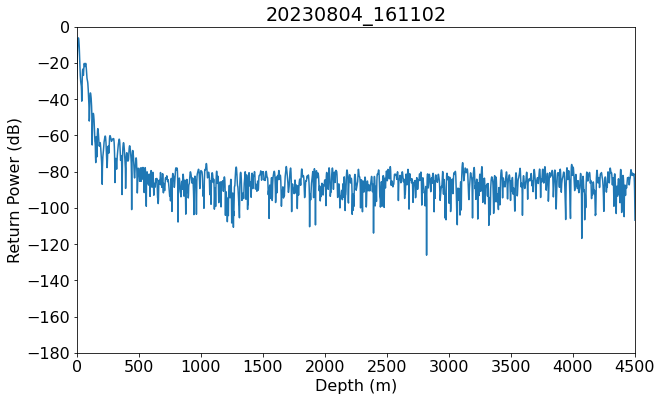

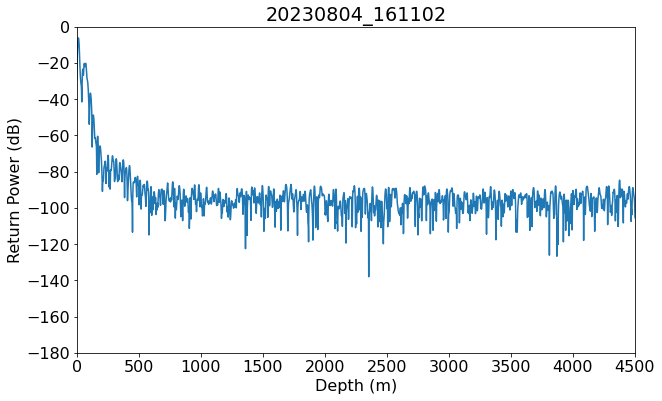

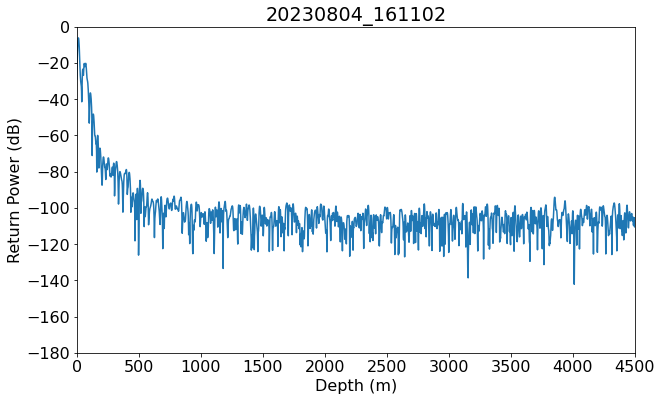

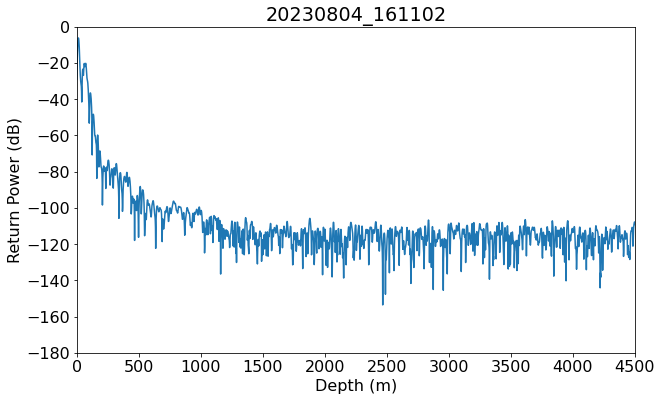

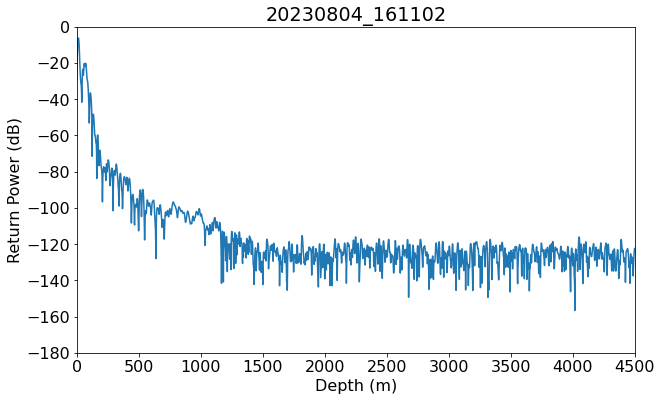

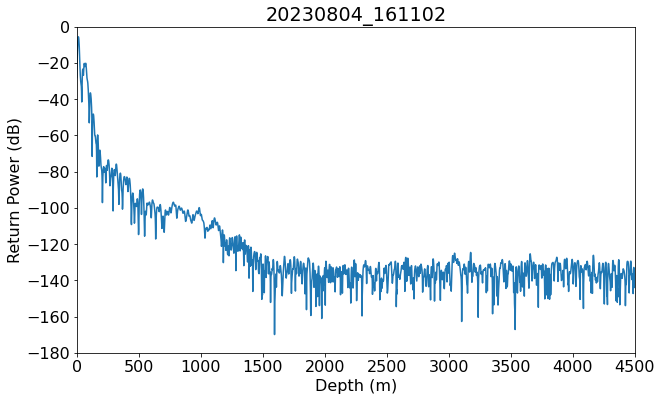

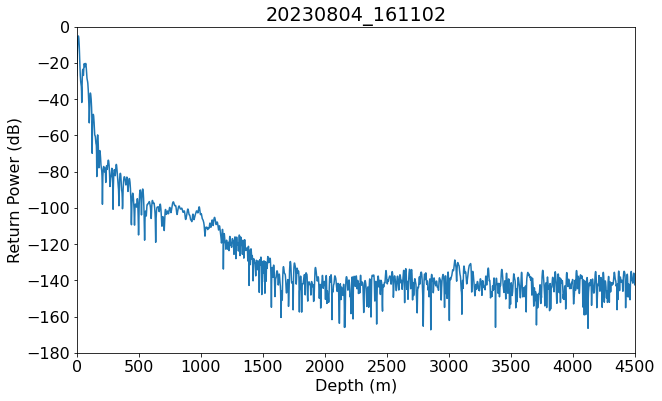

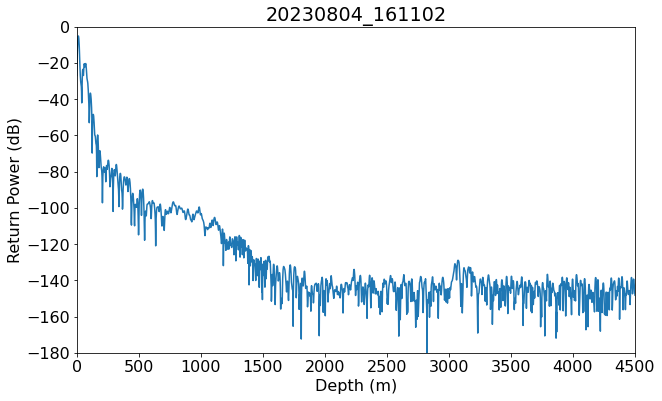

In [14]:
plots = []

#input_data = raw.where((raw.slow_time.compute() >= 95) & (raw.slow_time.compute() <= 115), drop=True) #.where(stacked.slow_time <= 115, drop=True).where(stacked.slow_time >= 95, drop=True)
#input_data = raw.where((raw.pulse_idx.compute() >= 55000) & (raw.pulse_idx.compute() <= 86000), drop=True) #.where(stacked.slow_time <= 115, drop=True).where(stacked.slow_time >= 95, drop=True)



compressed = pr.pulse_compress(raw, ref_chirp,
                                fs=raw.config['GENERATE']['sample_rate'],
                                zero_sample_idx=zero_sample_idx,
                                signal_speed=sig_speed)

for n_stack in [1, 10, 100, 1000, 10000, 100000, 500000, len(raw.pulse_idx)]:
#for n_stack in [1000, 5000, 6000, 7000, 8000, 9000, len(raw.pulse_idx)]:
#for n_stack in [10000, 100000, 300000, 500000, len(raw.pulse_idx)]:
    
    # test with detrending
    # detrended = xr.apply_ufunc(
    #     lambda x: sp.detrend(x, axis=0, type='constant'),
    #     raw,
    #     dask="parallelized"
    # )
    # stacked = pr.stack(detrended, n_stack)
    
    #stacked = pr.stack(input_data, n_stack)
        
    stacked = pr.stack(compressed, n_stack)
        
    # stacked = pr.stack(raw, n_stack)
    # compressed = pr.pulse_compress(stacked, ref_chirp,
    #                             fs=raw.config['GENERATE']['sample_rate'],
    #                             zero_sample_idx=zero_sample_idx,
    #                             signal_speed=sig_speed)

    compressed_power = xr.apply_ufunc(
        lambda x: 20*np.log10(np.abs(x)),
        stacked,
        dask="parallelized"
    )

    plots.append(compressed_power.radar_data[0,:].hvplot.line(label=f"{n_stack}"))
    #plots.append(compressed_power.radar_data.hvplot.line(label=f"{n_stack}"))
    
    fig, ax = plt.subplots(1,1, figsize=(10,6), facecolor='white')
    ax.plot(compressed_power.reflection_distance, compressed_power.radar_data[0,:])
    ax.set_xlabel('Depth (m)')
    ax.set_ylabel('Return Power (dB)')
    ax.set_title(raw.basename)
    ax.set_xlim(0, 4500)
    ax.set_ylim(-180, 0)

    fig.savefig(f'/Users/abroome/Desktop/Summit2023/figs/{raw.basename}_pulse_compressed_n{n_stack}_formatted.png', dpi=300)

plot1D = hv.Overlay(plots)
plot1D = plot1D.opts(xlabel='Reflection Distance (m)', ylabel='Return Power (dB)', height=600, title=f"1D Radargram Stacking Comparison [{os.path.basename(raw.prefix)}]")
#plot1D = plot1D.opts(xlim=(0, 1000), ylim=(-80, 0), show_grid=True)
plot1D

In [ ]:
#hvplot.save(plot1D, f"outputs/{os.path.basename(raw.prefix)}-1d-stack.png")
hvplot.save(plot1D, f"outputs/{os.path.basename(raw.prefix)}-1d-stack.html")

In [ ]:
plots = []

#input_data = raw.where((raw.slow_time.compute() >= 95) & (raw.slow_time.compute() <= 115), drop=True) #.where(stacked.slow_time <= 115, drop=True).where(stacked.slow_time >= 95, drop=True)
#input_data = raw.where((raw.pulse_idx.compute() >= 55000) & (raw.pulse_idx.compute() <= 86000), drop=True) #.where(stacked.slow_time <= 115, drop=True).where(stacked.slow_time >= 95, drop=True)

nstack = 10000

# test with detrending
# detrended = xr.apply_ufunc(
#     lambda x: sp.detrend(x, axis=0, type='constant'),
#     raw,
#     dask="parallelized"
# )
# stacked = pr.stack(detrended, n_stack)

#stacked = pr.stack(input_data, n_stack)

stacked = pr.stack(raw, nstack)
compressed = pr.pulse_compress(stacked, ref_chirp,
                            fs=raw.config['GENERATE']['sample_rate'],
                            zero_sample_idx=zero_sample_idx,
                            signal_speed=sig_speed)

compressed_power = xr.apply_ufunc(
    lambda x: 20*np.log10(np.abs(x)),
    compressed,
    dask="parallelized"
)

for ii in np.arange(0, len(raw.pulse_idx) // nstack):
    plots.append(compressed_power.radar_data[ii,:].hvplot.line(label=f"{n_stack}[{ii}]"))
    #plots.append(compressed_power.radar_data.hvplot.line(label=f"{n_stack}"))

plot1D = hv.Overlay(plots)
plot1D = plot1D.opts(xlabel='Reflection Distance (m)', ylabel='Return Power (dB)', height=600, title=f"1D Radargram Stacking Comparison [{os.path.basename(raw.prefix)}]")
#plot1D = plot1D.opts(xlim=(0, 1000), ylim=(-80, 0), show_grid=True)
plot1D

In [ ]:
hvplot.save(plot1D, f"outputs/{os.path.basename(raw.prefix)}_n{nstack}.png")
hvplot.save(plot1D, f"outputs/{os.path.basename(raw.prefix)}_n{nstack}.html")

In [ ]:
real_max = xr.apply_ufunc(
                lambda x: np.abs(np.real(x)),
                raw,
                dask="parallelized"
            ).max(dim='sample_idx')
imag_max = xr.apply_ufunc(
                lambda x: np.abs(np.imag(x)),
                raw,
                dask="parallelized"
            ).max(dim='sample_idx')
amplitude_plot = real_max.hvplot.line(label='Abs max of real part') * imag_max.hvplot.line(label='Abs max of imag part')
amplitude_plot

In [ ]:
hvplot.save(amplitude_plot, f"outputs/{os.path.basename(raw.prefix)}_raw_amplitudes.png")
hvplot.save(amplitude_plot, f"outputs/{os.path.basename(raw.prefix)}_raw_amplitudes.html")

In [ ]:
compressed = pr.pulse_compress(raw, ref_chirp,
                            fs=raw.config['GENERATE']['sample_rate'],
                            zero_sample_idx=zero_sample_idx,
                            signal_speed=sig_speed)

zero_idx_phase = xr.apply_ufunc(
                lambda x: np.angle(x),
                compressed,
                dask="parallelized")

phase_plot = (zero_idx_phase.radar_data[:,zero_sample_idx]*np.pi/180).hvplot.line(label='Phase of Zero Sample', x='pulse_idx')
phase_plot.opts(ylabel='Peak Phase (degrees)', xlabel='Pulse Index')
phase_plot

In [ ]:
hvplot.save(phase_plot, f"outputs/{os.path.basename(raw.prefix)}_zero_idx_phases.png")
hvplot.save(phase_plot, f"outputs/{os.path.basename(raw.prefix)}_zero_idx_phases.html")